In [1]:
import pylab
import numpy as np
np.seterr(all='raise')
np.random.seed(13)
import scipy as sp
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('text', usetex=True)
%matplotlib inline
from tqdm import tqdm

# Vamos a implementar leapfrog
1. La ecuación diferencial: Péndulo
$$\frac{d\theta}{dt}=\omega$$
$$\frac{d\omega}{dt}=-\frac{g}{l}\sin\theta$$
2. Condiciones iniciales: $\theta_0=0$, $\omega_0=1$
3. Resolvamos... desplazar $\omega$ un tiempo $\delta t/2$

In [2]:
g = 9.8
l = 1
def alpha(t,theta,omega):
    global g,l
    return -(g/l)*np.sin(theta)
def newOmega(dt,theta0,omega0,alpha):
    assert callable(alpha)
    alpha0 = alpha(0,theta0,omega0)
    # nuevo angulo
    theta = theta0 + omega0*dt+0.5*alpha0*dt**2 # Orden dt^3
    alpha1 = alpha(dt,theta,omega0) # ojo con omega0
    omega = omega0 + 0.25*(alpha1+alpha0)*dt
    return omega
def leapfrog(dt,t,theta,omega_dt2,alpha):
    assert callable(alpha)
    thetanuevo = theta + omega_dt2*dt
    alpha1 = alpha(t+dt,thetanuevo,omega_dt2) # ojo con el omega
    omeganuevo = omega_dt2 + alpha1 * dt
    return t+dt,thetanuevo,omeganuevo

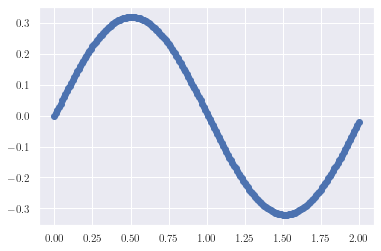

In [3]:
dt = 0.01
Xlist = [[0,0,newOmega(theta0=0,dt=dt,omega0=1,alpha=alpha)]]
for it in range(200):
    Xlist.append(leapfrog(dt,*Xlist[-1],alpha=alpha))
Xlist = np.array(Xlist)
plt.scatter(Xlist[:,0],Xlist[:,1])

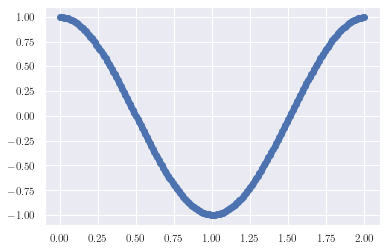

In [4]:
plt.scatter(Xlist[:,0],Xlist[:,2])

In [5]:
def newTheta(dt,theta0,omega0,alpha):
    assert callable(alpha)
    alpha0 = alpha(0,theta0,omega0)
    # nuevo angulo
    theta = theta0 + omega0*dt+0.5*alpha0*dt**2 # Orden dt^3
    return theta
def verlet(dt,t,theta,theta0,alpha):
    assert callable(alpha)
    alpha1 = alpha(t,theta,0) # ojo con el omega
    thetanuevo = 2*theta - theta0 + alpha1*dt**2
    return t+dt,thetanuevo,theta

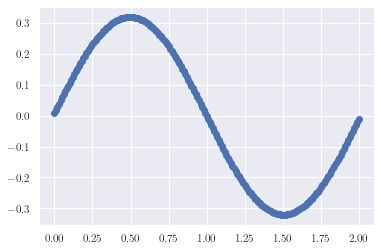

In [6]:
dt = 0.01
Xlist = [[0,newTheta(theta0=0,dt=dt,omega0=1,alpha=alpha),0]]
for it in range(200):
    Xlist.append(verlet(dt,*Xlist[-1],alpha=alpha))
Xlist = np.array(Xlist)
plt.scatter(Xlist[:,0],Xlist[:,1])

In [7]:
def ALPHA(X,t):
    global g,l
    return np.array([X[1],-(g/l)*np.sin(X[0])])
def rungekutta4(dt,t,X,Xprima):
    assert callable(Xprima)
    k1 = Xprima(X,t)*dt
    k2 = Xprima(X+k1/2,t+dt/2)*dt
    k3 = Xprima(X+k2/2,t+dt/2)*dt
    k4 = Xprima(X+k3,t+dt)*dt
    return t+dt,X+(k1+2*k2+2*k3+k4)/6

In [8]:
dt = 0.01
Xlist = [np.array([0,1])]
newT = 0
for it in range(200):
    newT,newX = rungekutta4(dt,newT,Xlist[-1],Xprima=ALPHA)
    Xlist.append(newX)
Xlist = np.array(Xlist)

# Gráfica del espacio de fase para el péndulo
$$ E = \frac{1}{2}m v^2 + mgl(1-\cos\theta)$$
Recordemos que $v=\omega l$. Asumiendo que $m=1$, $g=9.8$ y $l=1$. Condiciones iniciales $\theta=0$, $\omega=1$. Cuanta es la energia inicial? $E_0=1/2$
$$ E = \frac{1}{2}m (\omega l)^2 + mgl(1-\cos\theta)$$
Reemplazo $l=1$ y $m=1$,
$$ E = \frac{1}{2}\omega^2 + g(1-\cos\theta)$$
Para las condiciones iniciales, $E=1/2$. Sin embargo, como se conserva en todo momento (en el tiempo) la energía es constante

$$\omega^2+2g(1-\cos\theta)=1\to\omega=\sqrt{1-19.6(1-\cos\theta)}$$

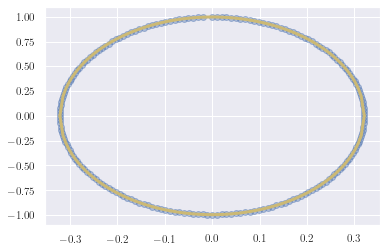

In [23]:
plt.scatter(Xlist[:,0],Xlist[:,1],alpha=0.4)
theta_x = np.linspace(-np.arccos(1-1/19.6),np.arccos(1-1/19.6),100)
omega_x = np.sqrt(1-19.6*(1-np.cos(theta_x)))
plt.plot(theta_x,omega_x,color='y',lw=3)
plt.plot(theta_x,-omega_x,color='y',lw=3)

# ¿Cómo podríamos nosotros resolver problemas donde las condiciones de frontera no necesariamente coresponden a las condiciones iniciales? Para ello se crean dos métodos: Diferencias finitas (Elementos finitos) y Shooting.
$$LeapFrog\to f'(x)\approx\frac{f(x+\delta x)-f(x-\delta x)}{2\delta x}$$
$$Verlet\to f''(x)\approx\frac{f(x+\delta x)+f(x-\delta x)-2f(x)}{\delta x^2}$$
¡Vamos a resolver el oscilador armónico simple desde un tiempo cero hasta un tiempo $T$!
$$\frac{d^2x}{dt^2}+\omega^2x=0$$
Discretizando el tiempo en $N$ particiones con (tal que $N\delta t = T$),
$$x(t)\equiv\mathbb{x}_t=(x(0),x(\delta t),x(2\delta t),\dots,x(T))^\text{T}=(x_0,x_1,x_2,\dots,x_N)^\text{T},$$
la ecuación diferencial "discretizada" queda,
$$x_{j+1}-2x_{j}+x_{j-1}+\omega^2\delta t^2x_{j}=0.$$
Las condiciones iniciales para este problema, $x(0)=a$ y $x'(0)=b$, traducen en términos discretos,
$$x_0=a,\,\,\,x_{-1}=x_0\left(1-\frac{\omega^2\delta t^2}{2}\right)-b\delta t,\,\,\,\text{y}\,\,\,x_{N+1}=-\frac{\omega^2\delta t^2}{2}x_0-\omega^2\delta t^2(x_2+x_3+\dots+x_{N-1})+(1-\omega^2\delta t^2)x_N+b\delta t.$$
Este es un sistema de $N+1$ ecuaciones lineales acopladas que se puede representar mediante una multiplicación matricial $\mathbb{M}\mathbb{x}_t=(\color{red}{-x_{-1}},0,0,\dots,0,0,\color{red}{-x_{N+1}})^\text{T}$ con,
$$\mathbb{M}(\omega,\delta t)=\left(\begin{array}{ccccccccc}
-2 + \omega^2\delta t^2 & 1 & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
1 & -2 + \omega^2\delta t^2 & 1 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & 1 & -2 + \omega^2\delta t^2 & 1 & \cdots & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & 1 & -2 + \omega^2\delta t^2 & 1 & 0 \\
0 & 0 & 0 & 0 & \cdots & 0 & 1 & -2 + \omega^2\delta t^2 & 1 \\
0 & 0 & 0 & 0 & \cdots & 0 & 0 & 1 & -2 + \omega^2\delta t^2 \\
\end{array}\right),$$
y en el que el lado derecho tiene igualmente una dependencia de $\mathbb{x}_t$. Luego, de manera general, podemos expresar la ecuación matricial maestra $\mathbb{M}\mathbb{x}_t=\mathbb{V}+\mathbb{\Lambda}\mathbb{x}_t$ donde $\mathbb{V}$ encierra todas las constantes y $\mathbb{\Lambda}$ los coeficientes de las contribuciones que dependen del vector de posiciones quienes dependen completamente de las condiciones de Frontera. Finalmente, la solución para las posiciones será: $\mathbb{x}_t=(\mathbb{M}-\mathbb{\Lambda})^{-1}\mathbb{V}$

In [48]:
a = 0; b = 1;
omega2 = 1
N = 50
T = 2*np.pi/np.sqrt(omega2)
dt = T/N
t = np.linspace(0,T,N+1)

Matriz $\mathbb{M}$

In [49]:
M = np.zeros(shape=(N+1,N+1))
# Agregar los términos de la ecuación diferencial
for l in range(N+1): # l corresponde a la fila
    if l==0:
        M[l,l]=-2+omega2*dt**2
        M[l,l+1]=1
    elif l==N:
        M[l,l-1]=1
        M[l,l]=-2+omega2*dt**2
    else:
        M[l,l-1]=1
        M[l,l]=-2+omega2*dt**2
        M[l,l+1]=1

Matrices $\mathbb{V}$ y $\mathbb{\Lambda}$ (Opción 1) para calcular la solución $\mathbb{x}_t$
$$x_{-1}=\underbrace{a\left(1-\frac{\omega^2\delta t^2}{2}\right)-b\delta t}_{\mathbb{V}},\,\,\,\text{y}\,\,\,x_{N+1}=\underbrace{-\omega^2\delta t^2(x_2+x_3+\dots+x_{N-1})+(1-\omega^2\delta t^2)x_N}_{\mathbb{\Lambda}}+\underbrace{b\delta t-\frac{\omega^2\delta t^2}{2}a}_{\mathbb{V}}.$$

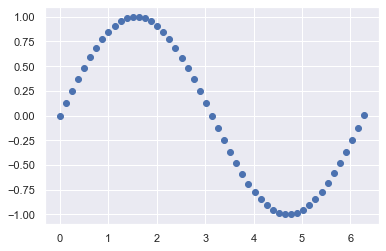

In [54]:
# Forma 1
LAMBDA = np.zeros(shape=(N+1,N+1))
for l in range(N+1):
    if l == 0:
        LAMBDA[N,l] = 0
    elif l == N:
        LAMBDA[N,l] = omega2*dt**2 - 1
    else:
        LAMBDA[N,l] = omega2*dt**2
V = np.zeros(shape=(N+1,1))
V[0,0] = dt*b-a*(1-omega2*dt*dt/2); V[N,0] = -dt*b+a*(omega2*dt*dt/2);
x_t = np.dot(np.linalg.inv(M-LAMBDA),V)
plt.scatter(t,x_t.T[0])

Matrices $\mathbb{V}$ y $\mathbb{\Lambda}$ (Opción 2) para calcular la solución $\mathbb{x}_t$
$$x_{-1}=\underbrace{-x_1}_{\mathbb{\Lambda}}+\underbrace{(2-\omega^2\delta t^2)a}_{\mathbb{V}},\,\,\,\text{y}\,\,\,x_{N+1}=\underbrace{(1-\omega^2\delta t^2)x_0-\omega^2\delta t^2(x_2+x_3+\dots+x_{N-1})+(1-\omega^2\delta t^2)x_N}_{\mathbb{\Lambda}}+\underbrace{b\delta t+\left(1-\frac{\omega^2\delta t^2}{2}\right)a}_{\mathbb{V}}.$$

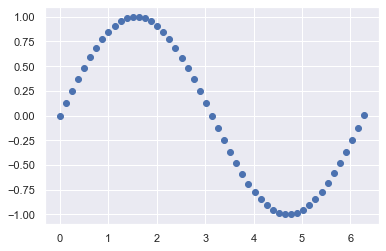

In [56]:
# Forma 2
LAMBDA = np.zeros(shape=(N+1,N+1))
LAMBDA[0,1] = 1
for l in range(N+1):
    if l == 0 or l == N:
        LAMBDA[N,l] = omega2*dt**2 - 1
    else:
        LAMBDA[N,l] = omega2*dt**2
V = np.zeros(shape=(N+1,1))
V[0,0] = a*(omega2*dt*dt-2); V[N,0] = -dt*b+a*(1-omega2*dt*dt/2);
Xsol = np.dot(np.linalg.inv(M-LAMBDA),V)
plt.scatter(t,Xsol.T[0])

# Pelota de fútbol
* [Drag y Magnus 1](https://www.researchgate.net/publication/228375759_Soccer_ball_lift_coefficients_via_trajectory_analysis)
* [Drag y Magnus 2](http://farside.ph.utexas.edu/teaching/329/lectures/node42.html)
* [Drag y Magnus 3](http://fse.studenttheses.ub.rug.nl/16434/1/Bsc_appliedMath_2017_Scholte_SIO.pdf)
* [Drag y Magnus 4](http://www.physics.usyd.edu.au/~cross/TRAJECTORIES/Sports%20Balls.pdf)